In [1]:
import os
import sys
import time
import warnings
import numpy as np
import rrsBdtDevDependencies
import dataFunctions as dataFun
from datetime import datetime as dt
from datetime import timedelta as td
import matplotlib.pyplot as plt
import pandas as pd
import quandl
QAPIKEY = "YpAydSEsKoSAfuQ9UKhu"
quandl.ApiConfig.api_key = QAPIKEY
import yfinance as yf
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import logging
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tqdm._tqdm_notebook import tqdm_notebook


Using TensorFlow backend.


In [2]:
### CONFIGURE ###

# Cost parameters set by the task for running ship for one day
barrels = 750000
costPerDay = 30000
daysToPredict = 1

# Data split for training and testing.
trainDataDate = '2010-01-01'
testSplitDate = '2019-11-26'

# Parameters for the model.
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 200,
    "lr": 0.0010000,
    "time_steps": 60
}

# Replace with Cloud path with data later on
PATH_TO_DRIVE_ML_DATA = os.environ['DF_ROOT']
INPUT_PATH = PATH_TO_DRIVE_ML_DATA+"/inputs/"
OUTPUT_PATH = PATH_TO_DRIVE_ML_DATA+"/outputs/"
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]

# Some environmental parameters.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TZ'] = 'Europe/London'
time.tzset()
stime = time.time()

modDate = dt.today().date()
dataDate = modDate - td(days=1)
updateData = False
is_update_model = True

dataFileName = "inputData_" + str(dataDate) + ".csv"
modFileName = "LSTM_" + str(modDate) + ".sav"

In [3]:
# check if directory already exists
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    print("Directory created", OUTPUT_PATH)
else:
    print("Directory "+OUTPUT_PATH+" exists.")

if not os.path.exists(INPUT_PATH):
    os.makedirs(INPUT_PATH)
    print("Directory created", INPUT_PATH)
else:
    print("Directory "+INPUT_PATH+" already exists.")



Exception: Directory already exists. Don't override.

In [4]:
def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ",np.round(seconds%60),"seconds")

In [5]:
print('Running...')

def show_more(df, lines):
    with pd.option_context("display.max_rows", lines):
        display(df)

Running...


In [6]:
def create_features(fd, features, label=None, shift = 0, nonShiftFeatures = None):
    fd = fd.set_index('Date')
    #X = df[['OilProduction', 'NatGasPrices', 'BrentPrices', '20dSMA', 'Momentum_14', 'MACD_12_26', 'MACDdiff_12_26', 'ROC_14', 'RSI_14', 'bollAmplitude', 'distFromTopBoll', 'distFromLowBoll', '20d200dDist','dayofyear','dayofmonth','weekofyear']]

    # X = df[['OilProduction', '20dSMA', 'Momentum_14', 'MACD_12_26', 'MACDdiff_12_26', 'ROC_14', 'RSI_14', 'bollAmplitude', 'distFromTopBoll', 'distFromLowBoll', '20d200dDist','dayofyear','dayofmonth','weekofyear']]
    # if shift > 0:
    #     tiems = X[['dayofyear','dayofmonth','weekofyear']]
    #     #X = X[['OilProduction', 'NatGasPrices', 'BrentPrices', '20dSMA', 'Momentum_14', 'MACD_12_26', 'MACDdiff_12_26','ROC_14', 'RSI_14', 'bollAmplitude', 'distFromTopBoll', 'distFromLowBoll', '20d200dDist']].shift(shift)
    #     X = X[['OilProduction', '20dSMA', 'Momentum_14', 'MACD_12_26', 'MACDdiff_12_26','ROC_14', 'RSI_14', 'bollAmplitude', 'distFromTopBoll', 'distFromLowBoll', '20d200dDist']].shift(shift)
    #     X = X.merge(tiems, how='inner', left_index=True, right_index=True)

    X = fd[features]
    if shift > 0:
        tiems = fd[nonShiftFeatures]
        newFeatures = features
        for f in nonShiftFeatures:
            newFeatures.remove(f)
        X = X[newFeatures].shift(shift)
        X = X.merge(tiems, how='inner', left_index=True, right_index=True)
        X = X.iloc[shift:]

    if label:
        y = fd[label]
        return X, y
    return X

In [7]:
"""
Getting WTI price data 
"""
quandlData = {
    "wti": {
        "quandlCode": "FRED/DCOILWTICO",
        "yahooCode": "CL=F",
        "yahooPeriod": "1d",
        "dfName": "Prices"
    },
    "oilProduction": {
        "quandlCode": "EIA/STEO_COPRPUS_M",
        "yahooCode": "",
        "yahooPeriod": "",
        "dfName": "OilProduction"
    },
    "natGas": {
        "quandlCode": "EIA/NG_RNGWHHD_D",
        "yahooCode": "NG=F",
        "yahooPeriod": "1d",
        "dfName": "NatGasPrices"
    },
    "brent": {
        "quandlCode": "FRED/DCOILBRENTEU",
        "yahooCode": "BZ=F",
        "yahooPeriod": "1d",
        "dfName": "BrentPrices"
    }
}

if updateData is False:
    df = pd.read_csv(INPUT_PATH+dataFileName)
    print("Dataframe already exists, reading from file...")
else:
    print("Datafile not found, querying data and building dataframe...")
    wtiData         = quandl.get("FRED/DCOILWTICO")
    wtiData.reset_index(level=0, inplace=True)
    wtiData         = wtiData.rename(columns={"Value": "Prices"})
    yfStartDate     = wtiData['Date'].iloc[-1].strftime('%Y-%m-%d')
    stocks          = "CL=F"
    period          = "1d"
    Stocks, yfInfo  = dataFun.yFinData(yfStartDate)
    wtiData         = wtiData.append(Stocks, ignore_index =True)
    wtiData         = wtiData.sort_values(by = ["Date"])

    # Getting Oil production data and combining dataframes
    oilDF   = dataFun.oilProduction()
    df      = dataFun.combineFrames(wtiData,oilDF)
    df      = df[np.isfinite(df['Prices'])]
    df      = df.reset_index().drop(["index"], axis = 1)

    # Getting natural gas data and combining frames
    natGasData          = quandl.get("EIA/NG_RNGWHHD_D")
    natGasData.reset_index(level=0, inplace=True)
    natGasData          = natGasData.rename(columns={"Value": "NatGasPrices"})
    yfStartDate         = natGasData['Date'].iloc[-1].strftime('%Y-%m-%d')
    stocks              = "NG=F"
    period              = "1d"
    NGStocks, yfInfo    = dataFun.yFinData(yfStartDate,stock=stocks,name ="NatGasPrices")
    natGasData          = natGasData.append(NGStocks, ignore_index =True)
    natGasData          = natGasData.sort_values(by = ["Date"])
    newdf               = pd.merge(df, natGasData, on=['Date'], how ="left")

    """
    Getting Brent oil data and combining dataframes
    """

    brentData = quandl.get("FRED/DCOILBRENTEU")
    brentData.reset_index(level=0, inplace=True)
    name = "BrentPrices"
    brentData = brentData.rename(columns={"Value": name})
    yfStartDate = brentData['Date'].iloc[-1].strftime('%Y-%m-%d')
    stocks = "BZ=F"
    period = "1d"
    BStocks, yfInfo = dataFun.yFinData(yfStartDate,stock=stocks,name = name)
    brentData = brentData.append(BStocks, ignore_index =True)
    brentData = brentData.sort_values(by = ["Date"])
    df = pd.merge(newdf, brentData, on=['Date'], how ="left")

    df["BrentPrices"] = df["BrentPrices"].interpolate(method='nearest')
    df["NatGasPrices"] = df["NatGasPrices"].interpolate(method='nearest')

    smas = {
        "5dSMA": 5,
        "10dSMA": 10,
        "20dSMA": 20,
        "50dSMA": 50,
        "200dSMA": 200
    }

    # Calculating the technical indicators for price data
    df = df.reset_index().drop(["index"], axis = 1)
    df = df.sort_values(by = ["Date"])

    for sma in smas:
        df[sma] = dataFun.SMA(smas[sma], df["Prices"])
        df[sma] = pd.to_numeric(df[sma])

    df["boll_lo"] = dataFun.bollinger(df['Prices'])[0]
    df["boll_hi"] = dataFun.bollinger(df['Prices'])[1]

    df = dataFun.momentum(df, 14)
    df = dataFun.macd(df, 12, 26)
    df = dataFun.rate_of_change(df, 14)
    df = dataFun.relative_strength_index(df)

    df["boll_hi"] = pd.to_numeric(df["boll_hi"])
    df["boll_lo"] = pd.to_numeric(df["boll_lo"])

    i = 0 
    j = 0
    for sma in smas:
        title = "daysAbove"+sma
        df[title] = float("NaN")
        for price,val,pos in zip(df["Prices"],df[sma],range(len(df))):
            if price > val:
                j = 0 
                i += 1 
                df[title].iloc[pos] = i
            elif val > price:
                i = 0
                j -= 1
                df[title].iloc[pos] = j
            else:
                i = 0
                j = 0
                df[title].iloc[pos] = 0


    df["bollAmplitude"] = df["boll_hi"] - df["boll_lo"]
    df["distFromTopBoll"] = df["boll_hi"] - df["Prices"]
    df["distFromLowBoll"] = df["boll_lo"] - df["Prices"]
    df["20d200dDist"] = np.abs(df["20dSMA"] - df["200dSMA"])

    df = df[np.isfinite(df['200dSMA'])]
    df = df.rename(columns={"Production of Crude Oil": "OilProduction"})
    df = df.drop_duplicates("Date",keep="first")
    df = df[np.isfinite(df['Prices'])]
    df = df.reset_index().drop(["index"], axis = 1)

    """
    Creating time series features from datetime index
    """

    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    df = df.sort_values(by='Date')

    print("Saving dataframe to file ", dataFileName, "at ", INPUT_PATH)
    df.to_csv(INPUT_PATH+dataFileName)


Datafile not found, querying data and building dataframe...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Saving dataframe to file  inputData_2020-02-13.csv at  /Users/qw19176/Documents/Courses/Team-Cpp/inputs/


In [8]:
df.tail()

,Date,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,200dSMA,...,distFromTopBoll,distFromLowBoll,20d200dDist,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
8395,2020-02-07,50.340000,13000.0,1.930,54.530000,54.5175,51.528,50.360,57.8002,57.03945,...,10.960000,-2.605000,2.52195,4,1,2,2020,38,7,6
8396,2020-02-10,49.590000,13000.0,1.850,53.390000,54.0460,51.178,50.266,57.6362,56.95620,...,11.231692,-2.319692,2.91020,0,1,2,2020,41,10,7
8397,2020-02-11,50.070000,13000.0,1.794,54.400002,50.8400,49.777,49.814,56.3218,56.40050,...,3.821309,-2.281308,5.56050,1,1,2,2020,42,11,7
8398,2020-02-12,51.450001,13000.0,1.850,56.279999,50.7080,49.888,50.154,56.1664,56.34625,...,1.921038,-3.405039,5.63825,2,1,2,2020,43,12,7
8399,2020-02-13,51.369999,13000.0,1.825,56.290001,50.6220,50.066,50.478,56.0190,56.29605,...,1.692981,-3.188979,5.67405,3,1,2,2020,44,13,7


In [9]:
df.describe()

,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,200dSMA,boll_lo,...,distFromTopBoll,distFromLowBoll,20d200dDist,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
count,8400.000000,8400.000000,5800.000000,8253.000000,8400.000000,8400.000000,8400.00000,8400.000000,8400.000000,8400.000000,...,8400.000000,8400.000000,8400.000000,8400.000000,8400.000000,8400.000000,8400.000000,8400.000000,8400.000000,8400.000000
mean,44.891013,6985.126190,4.265408,46.582273,44.848845,44.871617,44.88229,44.772807,44.390300,41.711302,...,3.095374,-3.179711,5.343586,2.013571,2.514167,6.541905,2002.905000,183.684643,15.720238,26.633452
std,29.154217,1744.495635,2.224255,32.707501,29.101958,29.127251,29.14033,29.011886,28.426925,27.468991,...,4.118863,3.427467,7.426407,1.399337,1.118543,3.443336,9.639447,105.146175,8.740798,15.025360
min,10.820000,3813.000000,1.050000,9.100000,11.228500,11.214000,10.99000,11.871200,13.363850,10.027444,...,-3.635005,-32.589390,0.001100,0.000000,1.000000,1.000000,1986.000000,2.000000,1.000000,1.000000
25%,19.930000,5721.000000,2.710000,18.750000,19.922750,19.929750,19.94500,19.957750,20.001288,18.855636,...,0.738756,-4.396328,1.394437,1.000000,2.000000,4.000000,1995.000000,92.000000,8.000000,14.000000
50%,32.180000,6499.000000,3.600000,31.620000,32.058250,31.976500,32.10800,31.997400,30.657400,28.968559,...,1.737363,-2.076606,2.927525,2.000000,3.000000,7.000000,2003.000000,184.000000,16.000000,27.000000
75%,64.020000,8026.000000,5.320000,67.520000,63.969625,64.257000,64.18450,63.630300,64.428987,59.676500,...,3.815169,-0.854328,6.285775,3.000000,4.000000,10.000000,2011.000000,275.000000,23.000000,40.000000
max,145.310000,13000.000000,18.480000,143.950000,138.824000,141.498000,142.29000,133.324400,112.504950,130.798978,...,51.571503,4.088349,60.175500,4.000000,4.000000,12.000000,2020.000000,366.000000,31.000000,53.000000


In [10]:
df[df.isna().any(axis=1)]

,Date,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,200dSMA,...,distFromTopBoll,distFromLowBoll,20d200dDist,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,1986-10-16,14.53,8773.0,NaN,NaN,14.7670,14.996,14.788,15.0902,14.93480,...,1.074970,-0.600970,0.16780,3,4,10,1986,289,16,42
1,1986-10-17,14.85,8773.0,NaN,NaN,14.7820,14.943,14.748,15.0912,14.88125,...,0.764336,-0.900336,0.09925,4,4,10,1986,290,17,42
2,1986-10-20,15.17,8773.0,NaN,NaN,14.8170,14.974,14.786,15.0910,14.82710,...,0.482958,-1.188958,0.01010,0,4,10,1986,293,20,43
3,1986-10-21,15.22,8773.0,NaN,NaN,14.8810,15.013,14.920,15.0988,14.77055,...,0.405210,-1.083210,0.11045,1,4,10,1986,294,21,43
4,1986-10-22,14.85,8773.0,NaN,NaN,14.9085,14.938,14.924,15.0974,14.71555,...,0.751177,-0.634177,0.19295,2,4,10,1986,295,22,43
5,1986-10-23,14.88,8773.0,NaN,NaN,14.9250,14.891,14.994,15.0850,14.66060,...,0.717137,-0.627137,0.26440,3,4,10,1986,296,23,43
6,1986-10-24,14.93,8773.0,NaN,NaN,14.9575,14.879,15.010,15.0780,14.60510,...,0.627285,-0.572285,0.35240,4,4,10,1986,297,24,43
7,1986-10-27,14.40,8773.0,NaN,NaN,14.9560,14.821,14.856,15.0574,14.54885,...,1.161463,-0.049463,0.40715,0,4,10,1986,300,27,44
8,1986-10-28,14.18,8773.0,NaN,NaN,14.9185,14.784,14.648,15.0244,14.49435,...,1.436566,0.040434,0.42415,1,4,10,1986,301,28,44
9,1986-10-29,13.73,8773.0,NaN,NaN,14.8700,14.674,14.424,14.9874,14.43815,...,2.014480,0.265520,0.43185,2,4,10,1986,302,29,44


In [167]:
def plot2axis(x, y1, x_name = "Date", y_name = "WTI Price (USD per Barrel)", color1 = "tab:black", 
              axis2 = False, y2 = [], y2_name = "", color2 = "tab:blue", 
              lineax1=False, lineax1y=0, lineax1name="", colorax1y = "tab:gray"
              lineax2=False, lineax2y=0, lineax2name="", colorax2y = "tab:orange"
              lineax3=False, lineax3y=0, lineax3name="", colorax3y = "tab:green"
              fill_boll=False, bol_low=[], bol_high=[], bol_name=""):

    import matplotlib.dates as mdates
    import matplotlib.ticker as ticker

    y1limtop = np.max(y1)+ np.max(y1)*0.05
    y1limbot = np.min(y1) - np.min(y1)*0.05
    y2limtop = np.max(y2) + np.max(y2)*0.05
    y2limbot = np.min(y2) - np.min(y2)*0.05
    datemin = np.datetime64(x.iloc[0], 'W')
    datemax = np.datetime64(x.iloc[-1], 'W') + np.timedelta64(1, 'W')


    plt.style.use("fivethirtyeight")

    fig, ax = plt.subplots(figsize=(16,10))
    # fig.figure(figsize=(20,15))

    color = color1
    ax.set_xlabel(x_name, size=28, labelpad=20)
    ax.set_ylabel(y_name, size=28, labelpad=20, color=color)
    ax.plot(x, y1, lw=2, color=color, label=y_name)
    # ax.plot(x, df["20dSMA"][-90:], "--", lw = 2, color = "tab:gray", label="20 Day SMA")
    ax.tick_params(axis='y', labelsize = 18, labelcolor=color)
    ax.tick_params(axis='x', labelsize = 18, labelcolor=color)
    ax.set_ylim(y1limbot, y1limtop)
    ax.set_xlim(datemin, datemax)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.legend(loc='left', bbox_to_anchor=(0.0, 0.075, 0.425, 0.9), prop={'size': 22})

    if axis2:
        ax2 = ax.twinx()
        color = color2
        
        # we already handled the x-label with ax
        ax2.set_ylabel(y2_name, size=28, labelpad=20, color=color)
        ax2.plot(x, y2, color=color, lw=2, label=y2_name)
        ax2.tick_params(axis='y', labelsize = 18, labelcolor=color)
        ax2.set_ylim(y2limbot, y2limtop)
        ax2.grid(None)
        # ax2.legend(loc='left', bbox_to_anchor=(0.0, -0.0375, 0.414, 0.9), prop={'size': 22})

    if lineax1:
        ax.plot(x, lineax1y, "--", linewidth=2, alpha=0.75, color=colorax1y, label=lineax1name)
        ax.legend(loc='left', bbox_to_anchor=(0.0, 0.075, 0.425, 0.9), prop={'size': 22})
        if axis2:
            ax2.legend(loc='left', bbox_to_anchor=(0.0, -0.0375, 0.414, 0.9), prop={'size': 22})

    elif lineax2:
        ax.plot(x, lineax1y, "--", linewidth=2, alpha=0.75, color=colorax1y, label=lineax1name)
        ax.plot(x, lineax2y, "--", linewidth=2, alpha=0.75, color=colorax2y, label=lineax2name)
        ax.legend(loc='left', bbox_to_anchor=(0.0, 0.075, 0.425, 0.9), prop={'size': 22})
        if axis2:
            ax2.legend(loc='left', bbox_to_anchor=(0.0, -0.0575, 0.414, 0.9), prop={'size': 22})

    elif lineax3:
        ax.plot(x, lineax1y, "--", linewidth=2, alpha=0.75, color=colorax1y, label=lineax1name)
        ax.plot(x, lineax2y, "--", linewidth=2, alpha=0.75, color=colorax2y, label=lineax2name)
        ax.plot(x, lineax3y, "--", linewidth=2, alpha=0.75, color=, label=lineax3name)
        ax.legend(loc='left', bbox_to_anchor=(0.0, 0.075, 0.425, 0.9), prop={'size': 22})
        if axis2:
            ax2.legend(loc='left', bbox_to_anchor=(0.0, -0.0775, 0.414, 0.9), prop={'size': 22})

    else:
        ax.legend(loc='left', bbox_to_anchor=(0.0, 0.075, 0.425, 0.9), prop={'size': 22})
        if axis2:
            ax2.legend(loc='left', bbox_to_anchor=(0.0, -0.01, 0.414, 0.9), prop={'size': 22})

    if fill_boll is True:
        # ax.axhspan(bol_low, bol_high, facecolor='blue', label=bol_name, alpha=0.75)
        ax.fill_between(x, bol_high, bol_low, color='tab:blue', alpha=0.25)
    
    # plt.subplots_adjust(left=0.1, right=0.5)
    fig.autofmt_xdate()
    fig.title(title, size = 36)
    fig.tight_layout()


In [171]:
for i, col in enumerate(cols): 
    print(i, col)

0 Date
1 Prices
2 OilProduction
3 NatGasPrices
4 BrentPrices
5 20dSMA
6 10dSMA
7 5dSMA
8 50dSMA
9 200dSMA
10 boll_lo
11 boll_hi
12 Momentum_14
13 MACD_12_26
14 MACDsign_12_26
15 MACDdiff_12_26
16 ROC_14
17 RSI_14
18 bollAmplitude
19 distFromTopBoll
20 distFromLowBoll
21 20d200dDist
22 dayofweek
23 quarter
24 month
25 year
26 dayofyear
27 dayofmonth
28 weekofyear


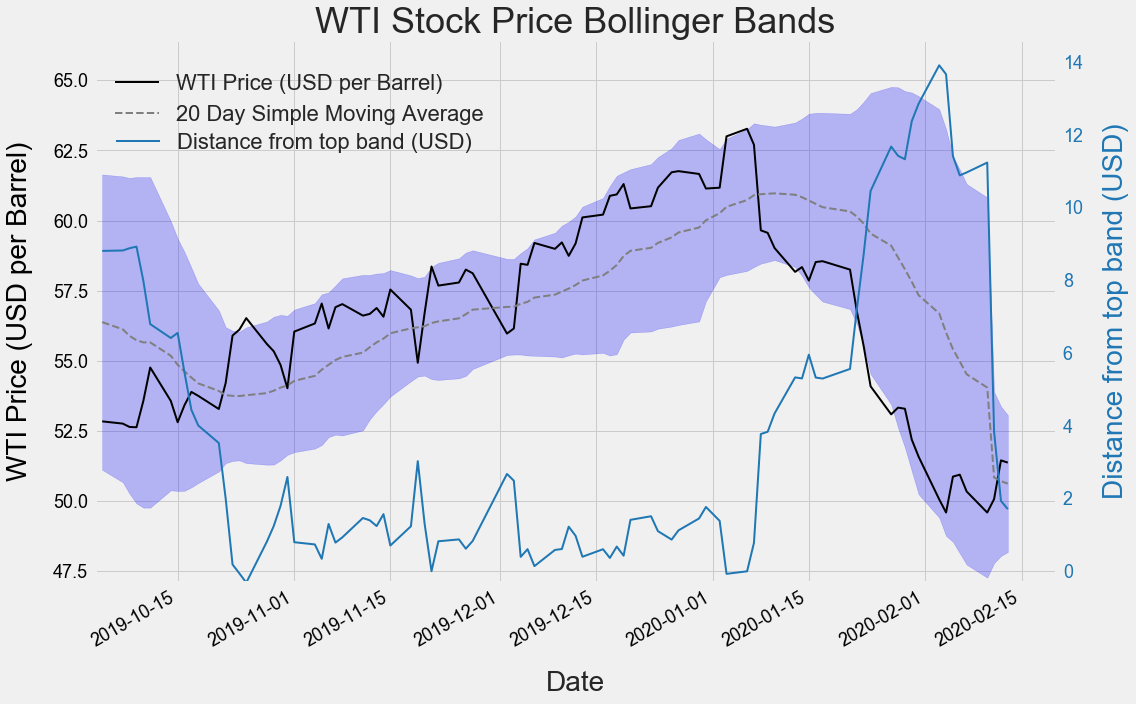

In [168]:
cols = df.columns
days = 90
dates = df["Date"][-days:]).astype('O')
prices = df["Prices"][-days:]
upBand = df["boll_hi"][-days:]
lowBand = df["boll_lo"][-days:]
bollName = "20d Bollinger Bands"
plotTitle = "WTI Oil Price " + col

for i, col in enumerate(cols): 
    print(col)
    if (col == "Date" or col == "Prices" or col == "20dSMA" or col == "boll_lo" or col == "boll_loo" or col ==:
        continue
    elif
plot2axis(x = pd.to_datetime(dates, y1 = prices, y_name = "WTI Price (USD per Barrel)", color1 = "black", lineax1y = df["20dSMA"][-days:], lineax1name = "20 Day SMA", axis2 = True, y2 = df["distFromTopBoll"][-days:], y2_name = "Distance from top band (USD)",fill_boll = True, bol_low = lowBand, bol_high = upBand, bol_name = bollName)


plt.title('WTI Stock Price Bollinger Bands', size = 36)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH+"featurePlots/", 'BollingerBands.png'), dpi=300, bbox_inches = "tight")

In [139]:
plt.style.use("fivethirtyeight")

    fig, ax = plt.subplots(figsize=(20,12))
    # fig.figure(figsize=(20,15))

 tab:blacklor = color1
    ax.set_xlabel(x_name, size=24)
    ax.set_ylabel(y_name, size=24, color=color)
    ax.plot(x, y1, lw=2, color=color, label=y_name)
    ax.tick_params(axis='y', 
ax.plot(pd.to_datetime(df["Date"][-90:]).astype('O'), df["Prices"][-90:], lw=2, color="tab:blue", label=y20 Day SMA)size = 16, labelcolor=color)
    fig.autofmt_xdate()

    if lineax1 is True:
        ax.plot(x, lineax1y, label=lineax1name,
                linewidth=2, alpha=0.75, color="orange")
        
    if fill_boll is True:
        # ax.axhspan(bol_low, bol_high, facecolor='blue', label=bol_name, alpha=0.75)
        ax.fill_between(x, bol_high,
                        bol_low, color='blue', alpha=0.33)
        
    ax.legend(loc='upper left', prop={'size': 24})
    
    if axis2 is True:
        ax2 = ax.twinx()
        color = color2
        
        # we already handled the x-label with ax
        ax2.set_ylabel(y2_name, size=20, color=color)
        ax2.plot(x, y2, color=color, lw=2, label=y2_name)
        ax2.tick_params(axis='y', t()

ax.plot(pd.to_datetime(df["Date"][-90:]).astype('O'), df["Prices"][-90:], lw=2, color="tab:blue", label=y_name)

plt.title('WTI Stock Price Bollinger Bands', size = 32)
plt.savefig(os.path.join(OUTPUT_PATH+"featurePlots/", 'BollingerBands.png'))

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 6)

In [12]:
df = df[df["Date"] > trainDataDate]
df = df.reset_index().drop(["index"], axis = 1)
# df_train = df[df["Date"] <= testSplitDate].copy()
# df_test = df[df["Date"] > testSplitDate].copy()
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
# df_train, df_test = train_test_split(df, train_size=0.9, test_size=0.1, shuffle=False)

# training_set = df.set_index('Date')
# training_set = training_set[features]
feat = ['Prices']#,'OilProduction', 'Momentum_14', 'RSI_14','distFromTopBoll', 'dayofmonth', 'weekofyear']#,'Momentum_14', 'MACD_12_26', 'RSI_14','20d200dDist','dayofmonth','weekofyear']
nonShiftFeat = ['Prices','dayofmonth','weekofyear']
#['OilProduction', '20dSMA', 'Momentum_14', 'MACD_12_26', 'MACDdiff_12_26', 'ROC_14', 'RSI_14', 'bollAmplitude', 'distFromTopBoll', 'distFromLowBoll', '20d200dDist','dayofyear','dayofmonth','weekofyear']


# X_train, y_train = create_features(df_train,features,label='Prices', shift =1)
# X_test, y_test = create_features(df_test,label='Prices', shift =1)
# X_train = X_train.iloc[1:]
# X_test = X_test.iloc[1:]
# y_train = y_train.iloc[1:]
# y_test = y_test.iloc[1:]

In [95]:
X = df[feat]
df_train[feat]
df_train[df_train.isna().any(axis=1)]
test = df_train.iloc[1:]
test

,Date,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,200dSMA,...,distFromTopBoll,distFromLowBoll,20d200dDist,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
1,2010-01-05,81.74,5507.0,6.19,79.27,74.7380,77.859,80.174,76.6768,67.53155,...,0.961614,-14.965614,7.20645,1,1,1,2010,5,5,1
2,2010-01-06,83.12,5507.0,6.47,80.14,75.1995,78.900,81.024,76.7370,67.68190,...,0.863697,-16.704697,7.51760,2,1,1,2010,6,6,1
3,2010-01-07,82.60,5507.0,7.51,80.57,75.7000,79.812,81.674,76.8168,67.82810,...,2.384600,-16.184600,7.87190,3,1,1,2010,7,7,1
4,2010-01-08,82.74,5496.0,6.56,80.06,76.3035,80.483,82.344,76.8826,67.98060,...,3.038614,-15.911614,8.32290,4,1,1,2010,8,8,1
5,2010-01-11,82.54,5496.0,5.77,80.14,76.9035,81.054,82.548,76.9856,68.12395,...,3.821668,-15.094668,8.77955,0,1,1,2010,11,11,2
6,2010-01-12,80.79,5496.0,5.57,79.38,77.4500,81.266,82.358,77.0046,68.26585,...,5.656388,-12.336388,9.18415,1,1,1,2010,12,12,2
7,2010-01-13,79.66,5496.0,5.61,77.57,77.9590,81.345,81.666,77.0570,68.42170,...,6.514810,-9.916810,9.53730,2,1,1,2010,13,13,2
8,2010-01-14,79.35,5496.0,5.77,77.61,78.3955,81.345,81.016,77.0824,68.57025,...,6.513130,-8.422130,9.82525,3,1,1,2010,14,14,2
9,2010-01-15,77.96,5404.0,5.66,76.85,78.6615,81.202,80.060,77.0500,68.71775,...,7.668110,-6.265110,9.94375,4,1,1,2010,15,15,2
10,2010-01-19,78.98,5404.0,5.51,75.18,78.9815,80.948,79.348,77.0236,68.84960,...,6.352690,-6.349690,10.13190,1,1,1,2010,19,19,3


In [96]:
df_train = create_features(df_train,features=feat, shift = 0, nonShiftFeatures=nonShiftFeat)
feat = ['Prices']#,'OilProduction', 'Momentum_14', 'RSI_14','distFromTopBoll', 'dayofmonth', 'weekofyear']#,'Momentum_14', 'MACD_12_26', 'RSI_14','20d200dDist','dayofmonth','weekofyear']
nonShiftFeat = ['Prices','dayofmonth','weekofyear']
df_test = create_features(df_test,features=feat, shift = 0, nonShiftFeatures=nonShiftFeat)



In [97]:
feat = ['Prices']#,'OilProduction', 'Momentum_14', 'RSI_14','distFromTopBoll', 'dayofmonth', 'weekofyear']#,'Momentum_14', 'MACD_12_26', 'RSI_14','20d200dDist','dayofmonth','weekofyear']
nonShiftFeat = ['Prices','dayofmonth','weekofyear']
x = df_train.loc[:,feat].values
x

array([[81.52],
       [81.74],
       [83.12],
       ...,
       [66.27],
       [65.71],
       [64.64]])

In [98]:

sc = MinMaxScaler(feature_range=(0,1))

x_train = sc.fit_transform(x)
x_test = sc.transform(df_test.loc[:,feat])
x_train

array([[0.63451835],
       [0.63704128],
       [0.65286697],
       ...,
       [0.45963303],
       [0.45321101],
       [0.44094037]])

In [99]:
def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x.shape,y.shape)
    return x, y


def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [100]:
tqdm_notebook.pandas('Processing...')
# df_ge = process_dataframe(df_ge)
print(df.shape)
print(df.columns)
print(df.dtypes)
print("Train--Test size", len(df_train), len(df_test))

(2543, 29)
Index(['Date', 'Prices', 'OilProduction', 'NatGasPrices', 'BrentPrices',
       '20dSMA', '10dSMA', '5dSMA', '50dSMA', '200dSMA', 'boll_lo', 'boll_hi',
       'Momentum_14', 'MACD_12_26', 'MACDsign_12_26', 'MACDdiff_12_26',
       'ROC_14', 'RSI_14', 'bollAmplitude', 'distFromTopBoll',
       'distFromLowBoll', '20d200dDist', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')
Date               datetime64[ns]
Prices                    float64
OilProduction             float64
NatGasPrices              float64
BrentPrices               float64
20dSMA                    float64
10dSMA                    float64
5dSMA                     float64
50dSMA                    float64
200dSMA                   float64
boll_lo                   float64
boll_hi                   float64
Momentum_14               float64
MACD_12_26                float64
MACDsign_12_26            float64
MACDdiff_12_26            float64
ROC_1

In [101]:
print("Are any NaNs present in train/test matrices?",np.isnan(x_train).any(), np.isnan(x_train).any())
target_idx = 0
x_t, y_t = build_timeseries(x_train, target_idx)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size",x_t.shape, y_t.shape)

Are any NaNs present in train/test matrices? False False
dim_0 1974



length of time-series i/o (1974, 60, 1) (1974,)
Batch trimmed size (1960, 60, 1) (1960,)


In [102]:
x_test_t

array([[[0.2875    ],
        [0.27075688],
        [0.22855505],
        ...,
        [0.36788991],
        [0.37155963],
        [0.3706422 ]],

       [[0.27075688],
        [0.22855505],
        [0.24965596],
        ...,
        [0.37155963],
        [0.3706422 ],
        [0.37729358]],

       [[0.22855505],
        [0.24965596],
        [0.22305046],
        ...,
        [0.3706422 ],
        [0.37729358],
        [0.37763761]],

       ...,

       [[0.32866972],
        [0.31915138],
        [0.34231651],
        ...,
        [0.31995413],
        [0.30848624],
        [0.31685779]],

       [[0.31915138],
        [0.34231651],
        [0.3456422 ],
        ...,
        [0.30848624],
        [0.31685779],
        [0.3086009 ]],

       [[0.34231651],
        [0.3456422 ],
        [0.3537844 ],
        ...,
        [0.31685779],
        [0.3086009 ],
        [0.30573393]]])

In [103]:
x_temp, y_temp = build_timeseries(x_test, target_idx)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)


dim_0 449



length of time-series i/o (449, 60, 1) (449,)
Test size (220, 60, 1) (220,) (220, 60, 1) (220,)


In [104]:
# lr = 0.1
# lstm_model = Sequential()
# lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
# lstm_model.add(Dropout(0.5))
# lstm_model.add(Dense(20,activation='relu'))
# lstm_model.add(Dense(1,activation='sigmoid'))
# optimizer = optimizers.RMSprop(lr=lr)
# lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

def create_model():
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model

# model = Sequential()
# model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50))
# model.add(Dropout(0.2))
# model.add(Dense(units=1))
# model.compile(optimizer='adam',loss='mean_squared_error')
# model.fit(X_train,y_train,epochs=100,batch_size=32)

In [105]:
model = None
try:
    model = pickle.load(open(modFileName, 'rb'))
    print("Loaded saved model...")
except FileNotFoundError:
    print("Model not found")

if model is None or is_update_model:
    from keras import backend as K
    print("Building model...")
    print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
    model = create_model()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
                          "best_model.h5"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)

    # Not used here. But leaving it here as a reminder for future
    r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
                                  verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
    
    history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])
    
    print("saving model...")
    pickle.dump(model, open(modFileName, "wb"))


Loaded saved model...
Building model...
checking if GPU available []
Train on 1960 samples, validate on 220 samples
Epoch 1/200
 - 6s - loss: 0.0087 - val_loss: 0.0110

Epoch 00001: val_loss improved from inf to 0.01097, saving model to /Users/qw19176/Documents/Courses/Team-Cpp/outputs/best_model.h5
Epoch 2/200
 - 6s - loss: 0.0085 - val_loss: 0.0100

Epoch 00002: val_loss improved from 0.01097 to 0.01002, saving model to /Users/qw19176/Documents/Courses/Team-Cpp/outputs/best_model.h5
Epoch 3/200
 - 6s - loss: 0.0082 - val_loss: 0.0135

Epoch 00003: val_loss did not improve from 0.01002
Epoch 4/200
 - 5s - loss: 0.0079 - val_loss: 0.0106

Epoch 00004: val_loss did not improve from 0.01002
Epoch 5/200
 - 6s - loss: 0.0074 - val_loss: 0.0114

Epoch 00005: val_loss did not improve from 0.01002
Epoch 6/200
 - 5s - loss: 0.0077 - val_loss: 0.0108

Epoch 00006: val_loss did not improve from 0.01002
Epoch 7/200
 - 5s - loss: 0.0068 - val_loss: 0.0145

Epoch 00007: val_loss did not improve fro

In [106]:
# OUTPUT_PATH = "/Users/qw19176/Documents/Courses/Team-Cpp/"
# csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'LSTMRegressor' + '.log'), append=True)
# epochs = 100
# history = lstm_model.fit(x_t, y_t, epochs=epochs, verbose=2, batch_size=BATCH_SIZE,
#                     shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
#                     trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])

In [107]:
# search_params = {
#     "batch_size": [20, 30, 40],
#     "time_steps": [30, 60, 90], 
#     "lr": [0.01, 0.001, 0.0001],
#     "epochs": [30, 50, 70]
# }

# def eval_model():
#     """
#     implement your logic to build a model, train it and then calculate validation loss.
#     Save this validation loss using CSVLogger of Keras or in a text file. Later you can
#     query to get the best combination.
#     """
#     pass

# def get_all_combinations(params):
#     all_names = params.keys()
#     combinations = it.product(*(params[name] for name in all_names))
#     return list(combinations)

# def run_search(mat, params):
#     param_combs = get_all_combinations(params) # list of tuples
#     logging.info("Total combinations to try = {}".format(len(param_combs)))
#     for i, combination in enumerate(param_combs):
#         logging.info("Trying combo no. {} {}".format(i, combination))
#         eval_model(mat, combination, i)

# run_search(x_input, search_params)

In [108]:
# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 0.0013367554730999915 (220,) (220,)
[0.4046405  0.4067725  0.40894806 0.4157905  0.41832554 0.41009966
 0.40435857 0.41289032 0.41554144 0.41262668 0.41734177 0.42996114
 0.44551978 0.448498   0.44256294]
[0.37729358 0.37763761 0.3891055  0.3875     0.37477064 0.37293578
 0.38623853 0.38073394 0.37958716 0.38990826 0.4059633  0.41674312
 0.41594037 0.41204128 0.42327982]


In [109]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * sc.data_range_[target_idx]) + sc.data_min_[target_idx]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * sc.data_range_[target_idx]) + sc.data_min_[target_idx]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[61.474648 61.66056  61.850273 62.44693  62.667984 61.95069  61.450066
 62.19404  62.42521  62.171043 62.5822   63.68261  65.03932  65.29903
 64.78149 ]
[59.09 59.12 60.12 59.98 58.87 58.71 59.87 59.39 59.29 60.19 61.59 62.53
 62.46 62.12 63.1 ]


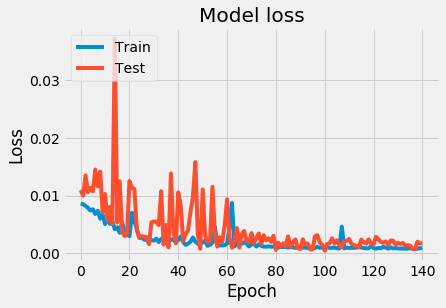

In [110]:
# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))

In [111]:
# load the saved best model from above
saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
print(saved_model)

In [112]:
y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * sc.data_range_[target_idx]) + sc.data_min_[target_idx] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * sc.data_range_[target_idx]) + sc.data_min_[target_idx] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

Error is 0.0002932517671356911 (220,) (220,)
[0.3655116  0.3670417  0.36851603 0.374553   0.37975743 0.3764159
 0.36997798 0.37166727 0.3752687  0.37610394 0.37828228 0.38678002
 0.39889655 0.40554473 0.40373126]
[0.37729358 0.37763761 0.3891055  0.3875     0.37477064 0.37293578
 0.38623853 0.38073394 0.37958716 0.38990826 0.4059633  0.41674312
 0.41594037 0.41204128 0.42327982]
[58.06261  58.196037 58.3246   58.85102  59.304848 59.013466 58.45208
 58.59939  58.91343  58.98626  59.176216 59.91722  60.973778 61.553497
 61.395363]
[59.09 59.12 60.12 59.98 58.87 58.71 59.87 59.39 59.29 60.19 61.59 62.53
 62.46 62.12 63.1 ]


program completed  315.0 minutes :  36.0 seconds


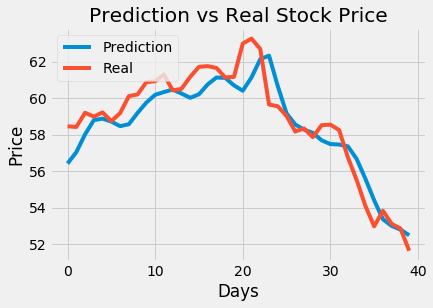

In [113]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org[-40:])
plt.plot(y_test_t_org[-40:])
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
print_time("program completed ", stime)

In [117]:
y_pred = saved_model.predict(trim_dataset(x_new_t,BATCH_SIZE), batch_size=BATCH_SIZE)
#y_pred = y_pred.flatten()
y_new_t = trim_dataset(y_new_t, BATCH_SIZE)
error = mean_squared_error(y_new_t, y_pred)
print("Mean squared error is", error, y_pred.shape, y_new_t.shape)
# print(y_pred[0:15])
# print(y_test_t[0:15])
y_pred_org = (y_pred * sc.data_range_[target_idx]) + sc.data_min_[target_idx] # min_max_scaler.inverse_transform(y_pred)
y_new_t_org = (y_new_t * sc.data_range_[target_idx]) + sc.data_min_[target_idx] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[-40:])
print(y_new_t_org[-40:-23])

Mean squared error is 0.00014457620952733384 (40, 1) (40,)
[[60.242752]
 [60.396088]
 [60.542336]
 [60.3254  ]
 [60.078506]
 [60.26024 ]
 [60.78853 ]
 [61.148438]
 [61.11104 ]
 [60.698547]
 [60.401825]
 [61.11882 ]
 [62.10131 ]
 [62.26931 ]
 [60.582993]
 [59.07138 ]
 [58.437683]
 [58.13398 ]
 [57.925507]
 [57.490906]
 [57.49492 ]
 [57.469856]
 [57.37119 ]
 [56.680126]
 [55.58886 ]
 [54.406067]
 [53.360363]
 [52.991463]
 [52.7879  ]
 [52.472084]
 [51.74054 ]
 [50.89917 ]
 [50.07191 ]
 [49.502056]
 [49.678474]
 [50.2183  ]
 [50.321186]
 [49.91735 ]
 [49.514908]
 [49.517326]]
[60.93 61.3  60.43 60.51 61.17 61.72 61.76 61.66 61.14 61.17 63.   63.27
 62.7  59.65 59.56 59.02 58.17]


In [116]:
to_pred = df["Prices"][-139:].values
to_pred = np.append(to_pred,50)
# trim_dataset(x_test_t, BATCH_SIZE)
to_pred = sc.transform(to_pred.reshape(-1,1))
x_new, y_new = build_timeseries(to_pred, target_idx)
x_newval, x_new_t = np.split(trim_dataset(x_new,BATCH_SIZE),2)
y_newval, y_new_t = np.split(trim_dataset(y_new,BATCH_SIZE),2)
to_pred.shape
# print("Test size", x_new_t.shape, y_new_t.shape, x_newval.shape, y_newval.shape)

dim_0 80



length of time-series i/o (80, 60, 1) (80,)


(140, 1)

In [278]:
df["Prices"][-61:]

2480    56.670000
2481    56.880000
2482    56.570000
2483    57.540000
2484    56.820000
          ...    
2536    49.680000
2537    51.230000
2538    51.369999
2539    50.340000
2540    49.759998
Name: Prices, Length: 61, dtype: float64

In [176]:
df.tail(5)

,Unnamed: 0,Date,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,...,distFromTopBoll,distFromLowBoll,20d200dDist,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
2536,8393,2020-02-04,49.680000,12900.0,1.879,53.880001,52.4595,49.049999,45.225999,57.0044,...,16.677633,-11.118634,4.26465,1,1,2,2020,35,4,6
2537,8394,2020-02-05,51.230000,12900.0,1.874,55.630001,52.1280,48.875999,50.359999,56.9096,...,14.568172,-12.772171,4.53585,2,1,2,2020,36,5,6
2538,8395,2020-02-06,51.369999,12900.0,1.864,55.380001,51.7705,48.630999,50.431999,56.8140,...,13.736722,-12.935721,4.83325,3,1,2,2020,37,6,6
2539,8396,2020-02-07,50.340000,12900.0,1.850,54.450001,51.3600,48.354999,50.512000,56.6516,...,13.977621,-11.937622,5.17630,4,1,2,2020,38,7,6
2540,8397,2020-02-09,49.759998,12900.0,1.791,53.849998,50.9355,48.045999,50.475999,56.4784,...,13.732812,-11.381809,5.53185,6,1,2,2020,40,9,6


In [ ]:
"""
TALOS OPTIMISATION

NOT IMPLEMENTED YET
"""

def data(search_params):
    """
    The function that prepares the data for LSTM training specific to this problem as per values in search_params.
    """
    global mat

    BATCH_SIZE = search_params["batch_size"]
    TIME_STEPS = search_params["time_steps"]
    x_train, x_test = train_test_split(mat, train_size=0.8, test_size=0.2, shuffle=False)

    # scale the train and test dataset
    min_max_scaler = MinMaxScaler()
    x_train = min_max_scaler.fit_transform(x_train)
    x_test = min_max_scaler.transform(x_test)

    x_train_ts, y_train_ts = build_timeseries(x_train, 3, TIME_STEPS)
    x_test_ts, y_test_ts = build_timeseries(x_test, 3, TIME_STEPS)
    x_train_ts = trim_dataset(x_train_ts, BATCH_SIZE)
    y_train_ts = trim_dataset(y_train_ts, BATCH_SIZE)
    x_test_ts = trim_dataset(x_test_ts, BATCH_SIZE)
    y_test_ts = trim_dataset(y_test_ts, BATCH_SIZE)
    print("Test size(trimmed) {}, {}".format(x_test_ts.shape, y_test_ts.shape))
    return x_train_ts, y_train_ts, x_test_ts, y_test_ts
  
  def create_model_talos(x_train_ts, y_train_ts, x_test_ts, y_test_ts, params):
    """
    function that builds model, trains, evaluates on validation data and returns Keras history object and model for
    talos scanning. Here I am creating data inside function because data preparation varies as per the selected value of 
    batch_size and time_steps during searching. So we ignore data that's received here as argument from scan method of Talos.
    """
    x_train_ts, y_train_ts, x_test_ts, y_test_ts = data(params)
    BATCH_SIZE = params["batch_size"]
    TIME_STEPS = params["time_steps"]
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(params["lstm1_nodes"], batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_train_ts.shape[2]), dropout=0.2,
                        recurrent_dropout=0.2, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    if params["lstm_layers"] == 2:
        lstm_model.add(LSTM(params["lstm2_nodes"], dropout=0.2))
    else:
        lstm_model.add(Flatten())

    if params["dense_layers"] == 2:
        lstm_model.add(Dense(params["dense2_nodes"], activation='relu'))

    lstm_model.add(Dense(1, activation='sigmoid'))
    if params["optimizer"] == 'rms':
        optimizer = optimizers.RMSprop(lr=params["lr"])
    else:
        optimizer = optimizers.SGD(lr=params["lr"], decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)  # binary_crossentropy
    history = lstm_model.fit(x_train_ts, y_train_ts, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                             validation_data=[x_test_ts, y_test_ts],
                             callbacks=[LogMetrics(search_params, params, -1), csv_logger])
    return history, lstm_model
  
print("Starting Talos scanning...")
t = ta.Scan(x=mat, # data parameter is ignored in this example as here data varies based on batch_size & time_steps
            y=mat[:,0], # dummy data just to avoid errors. input and output calculated in create_model_talos
            model=create_model_talos,
            params=search_params,
            dataset_name='stock_ge',
            experiment_no='1',
            reduction_interval=10)

pickle.dump(t, open(os.path.join(OUTPUT_PATH,"talos_res"),"wb"))

In [5]:
features = ["easy", "easter", "eastmas", "estover"]
nonShiftFeatures = ["easy", "easter"]


In [7]:
for f in nonShiftFeatures:
    features.remove(f)
features

['eastmas', 'estover']